# Visualizing LFP Responses to Stimulus
A very useful view when working with ecephys data is the *LFP trace*. LFP, or Local Field Potential is the electrical potential recorded in the extracellular space in brain tissue that represents activity in regions of neurons. This is particularly useful when you examine LFP responses to stimulus events. The type of stimulus can vary, but in order to visualize this, you must have access to the times of the stimulus events you're interested in. In this notebook, you can extract data from a stimulus NWB file and an LFP NWB file. Importantly, since the stimulus timestamps and the LFP timestamps are not likely to be aligned with each other and in perfectly regular intervals, they must be interpolated.

### Environment Setup

In [1]:
### if running on Google Colab, run this cell once, then restart the runtime and run the rest of the notebook
import os
if "COLAB_GPU" in os.environ:
    !git clone https://github.com/AllenInstitute/openscope_databook.git
    %cd openscope_databook
    %pip install -e .

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from dandi_utils import dandi_download_open
from math import sqrt
from scipy import interpolate

### Downloading Ecephys Files
If you don't already have files to analyze, you can use data from The Allen Institute's **Visual Coding - Neuropixels** dataset. If you want to choose your own files to download, set `dandiset_id`, `dandi_stim_filepath`, `dandi_lfp_filepath` accordingly. When accessing an embargoed dataset, set `dandi_api_key` to be your DANDI API key.

In [3]:
dandiset_id = "000021"
dandi_stim_filepath = "sub-730756767/sub-730756767_ses-757970808.nwb"
dandi_lfp_filepath = "sub-730756767/sub-730756767_ses-757970808_probe-769322852_ecephys.nwb"
download_loc = "."
dandi_api_key = None

In [4]:
# This can sometimes take a while depending on the size of the file
stim_nwb = dandi_download_open(dandiset_id, dandi_stim_filepath, download_loc, dandi_api_key=dandi_api_key)
lfp_nwb = dandi_download_open(dandiset_id, dandi_lfp_filepath, download_loc, dandi_api_key=dandi_api_key)

A newer version (0.55.1) of dandi/dandi-cli is available. You are using 0.46.6


File already exists
Opening file


c:\Users\katrina.ager\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.6.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
c:\Users\katrina.ager\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


PATH                                                    SIZE   DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-730756767_ses-757970808_probe-769322852_ecephys.nwb 2.3 GB 2.3 GB           100%    ok    done                   
Summary:                                                2.3 GB 2.3 GB                         1 done                 
                                                               100.00%                                               
Downloaded file to ./sub-730756767_ses-757970808_probe-769322852_ecephys.nwb
Opening file


### Reading LFP Data and Stimulus Data
Below, the stimulus data and the LFP data are read from their respective files. The LFP object, which contains a `data` and a `timestamps` array, is read in from the probe file. In this example, the lfp information is stored in an item called `probe_769322852_lfp_data`, but it will be named differently if you are using a different nwb file. The LFP `data` array should be a two-dimensional array with shape `n * t`, where n is the number of channels on the probe, and t is the number of measurements through time.

In [5]:
lfp = lfp_nwb.acquisition["probe_769322852_lfp_data"]
lfp

probe_769322852_lfp_data pynwb.ecephys.ElectricalSeries at 0x2957991865600
Fields:
  comments: no comments
  conversion: 1.0
  data: <HDF5 dataset "data": shape (12085040, 89), type "<f4">
  description: no description
  electrodes: electrodes <class 'hdmf.common.table.DynamicTableRegion'>
  interval: 1
  offset: 0.0
  resolution: -1.0
  timestamps: <HDF5 dataset "timestamps": shape (12085040,), type "<f8">
  timestamps_unit: seconds
  unit: volts

### Extracting Stimulus Times
First, you must take a stimulus table from your stimulus file. Since your stimulus table will be unique to your experiment, you'll have to use some ingenuity to extract the timestamps that are of interest to you. Below, the names of various stimulus tables. Set `stim_name` to be the name that contains the associated stimulus table you want. You can see that the stimulus table contains the `start_time` of each stimulus event. In the cell below that's commented `select start times from table that fit certain critera here`, you should write code to iterate through this table and get all the start times from the rows that contain an the important stimulus you're interested in. The output should be a list of timestamps.

In [6]:
stim_nwb.intervals.keys()

dict_keys(['drifting_gratings_presentations', 'flashes_presentations', 'gabors_presentations', 'natural_movie_one_presentations', 'natural_movie_three_presentations', 'natural_scenes_presentations', 'spontaneous_presentations', 'static_gratings_presentations'])

In [7]:
# select stimulus table from above and insert here
stim_name = "static_gratings_presentations"
stim_table = stim_nwb.intervals[stim_name]
stim_table[:10]

,start_time,stop_time,stimulus_name,stimulus_block,color,mask,opacity,phase,size,units,stimulus_index,orientation,spatial_frequency,contrast,tags,timeseries
id,,,,,,,,,,,,,,,,
0,5399.014151,5399.264360,static_gratings,8.0,"[1.0, 1.0, 1.0]",None,1.0,0.25,"[250.0, 250.0]",deg,6.0,90.0,0.08,0.8,[stimulus_time_interval],"[(49434, 1, timestamps pynwb.base.TimeSeries a..."
1,5399.264360,5399.514570,static_gratings,8.0,"[1.0, 1.0, 1.0]",None,1.0,0.0,"[250.0, 250.0]",deg,6.0,150.0,0.02,0.8,[stimulus_time_interval],"[(49435, 1, timestamps pynwb.base.TimeSeries a..."
2,5399.514570,5399.764780,static_gratings,8.0,"[1.0, 1.0, 1.0]",None,1.0,0.5,"[250.0, 250.0]",deg,6.0,60.0,0.32,0.8,[stimulus_time_interval],"[(49436, 1, timestamps pynwb.base.TimeSeries a..."
3,5399.764780,5400.014989,static_gratings,8.0,"[1.0, 1.0, 1.0]",None,1.0,0.75,"[250.0, 250.0]",deg,6.0,150.0,0.32,0.8,[stimulus_time_interval],"[(49437, 1, timestamps pynwb.base.TimeSeries a..."
4,5400.014989,5400.265187,static_gratings,8.0,"[1.0, 1.0, 1.0]",None,1.0,0.25,"[250.0, 250.0]",deg,6.0,60.0,0.32,0.8,[stimulus_time_interval],"[(49438, 1, timestamps pynwb.base.TimeSeries a..."
5,5400.265187,5400.515385,static_gratings,8.0,"[1.0, 1.0, 1.0]",None,1.0,0.25,"[250.0, 250.0]",deg,6.0,150.0,0.04,0.8,[stimulus_time_interval],"[(49439, 1, timestamps pynwb.base.TimeSeries a..."
6,5400.515385,5400.765583,static_gratings,8.0,"[1.0, 1.0, 1.0]",None,1.0,0.5,"[250.0, 250.0]",deg,6.0,150.0,0.04,0.8,[stimulus_time_interval],"[(49440, 1, timestamps pynwb.base.TimeSeries a..."
7,5400.765583,5401.015781,static_gratings,8.0,"[1.0, 1.0, 1.0]",None,1.0,0.25,"[250.0, 250.0]",deg,6.0,150.0,0.04,0.8,[stimulus_time_interval],"[(49441, 1, timestamps pynwb.base.TimeSeries a..."
8,5401.015781,5401.266003,static_gratings,8.0,"[1.0, 1.0, 1.0]",None,1.0,0.25,"[250.0, 250.0]",deg,6.0,150.0,0.02,0.8,[stimulus_time_interval],"[(49442, 1, timestamps pynwb.base.TimeSeries a..."


In [8]:
### select start times from table that fit certain critera here

stim_select = lambda row: float(row.orientation) == 150.0
# for rows that satisfy condition above, extracts the start time and adds it to 'all_stim_times' list
all_stim_times = [float(row.start_time) for row in stim_table if stim_select(row)]
print("There are", len(all_stim_times), "stimulus times from rows that satisfy the condition.")

There are 976 stimulus times from rows that satisfy the condition.


### Selecting a Period
Oftentimes, the LFP data can be very large. Depending on the machine this analysis is performed on, there may not be enough memory to perform this interpolation. This can be mitigated in two ways. Firstly, the `interp_hz` variable in the following section can be decreased. Otherwise, the analysis can be performed with some smaller period of time within the LFP data. If you wish to do this, set `period_start` and `period_end` to be reasonable times (in seconds) within the experiment to look at. Below are printed the first and last timestamps from the stimulus data and LFP data to inform this choice. Also printed below are the shapes of `lfp_timestamps` and `lfp_data`. `lfp_timestamps` is a 1D array with a length of n, where n is the number of timestamps for the given period. `lfp_data` is a 2D array with a shape of n * p, where p is the number of probes. 


In [9]:
print("First timestamp stimulus data: ", all_stim_times[0])
print("Last timestamp stimulus data: ", all_stim_times[-1])
print("First timestamp LFP data: ", lfp.timestamps[0])
print("Last timestamp LFP data: ", lfp.timestamps[-1])

First timestamp stimulus data:  5399.264360458158
Last timestamp stimulus data:  9151.149149224091
First timestamp LFP data:  3.727534675412933
Last timestamp LFP data:  9671.771044169622


In [10]:
# period_start = lfp.timestamps[0]
period_start = 5000
# period_end = lfp.timestamps[-1]
period_end = 5800

In [17]:
# filter stim_timestamps to just timestamps within period
stim_times = np.array([ts for ts in all_stim_times if ts >= period_start and ts <= period_end])
if len(stim_times) == 0:
    raise ValueError("There are no stimulus timestamps in that period")


# find indices within lfp data that correspond to period bounds
period_start_idx, period_end_idx = None, None
for i, ts in enumerate(lfp.timestamps):
    if not period_start_idx and ts >= period_start:
        period_start_idx = i
    if period_start_idx and ts >= period_end:
        period_end_idx = i
        break

if period_start_idx == None or period_end_idx == None:
    raise ValueError("Period bounds not found within lfp data")

# get slice of LFP data corresponding to the period bounds
lfp_timestamps = lfp.timestamps[period_start_idx:period_end_idx]
lfp_data = lfp.data[period_start_idx:period_end_idx]

[]


In [19]:
print("number of times selected stimulus was presented during this period: ", stim_times.shape)
print(lfp_timestamps.shape)
print(lfp_data.shape)

number of times stimulus was presented during this period:  (267,)
(999999,)
(999999, 89)


### LFP Interpolation
Because we cannot be certain that the LFP trace is at a perfectly regular Hz, we will interpolate it to be able to compare stimulus timestamps to their approximate LFP times. After you have a valid list of stimulus timestamps, you can generate a linearly-spaced timestamp array called `time_axis`, and interpolate the LFP data along it, making interpolated LFP data called `interp_lfp`. This should be a 2D array with dimensions `time` and `channel`, where channels are the different measurement channels along the probe. Here, the timestamps are interpolated to 250 Hertz, but you can change this by setting `interp_hz`.

In [20]:
interp_hz = 250

In [21]:
print(lfp_timestamps.shape)
print(lfp_data.shape)

(999999,)
(999999, 89)


In [22]:
# generate regularly-space x values and interpolate along it
time_axis = np.arange(lfp_timestamps[0], lfp_timestamps[-1], step=(1/interp_hz))
interp_channels = []

# interpolate channel by channel to save RAM
for channel in range(lfp_data.shape[1]):
    f = interpolate.interp1d(lfp_timestamps, lfp_data[:,channel], axis=0, kind="nearest", fill_value="extrapolate")
    interp_channels.append(f(time_axis))

interp_lfp = np.transpose(interp_channels)

print(interp_lfp.shape)

(200000, 89)


### Getting Stimulus Time Windows
Now that you have your interpolated LFP data, you can use the stimulus times to identify the windows of time in the LFP data that exist around a stimulus event. Since the LFP data have been interpolated, we can easily translate timestamps to indices within the LFP trace array. Set `window_start_time` to be a negative number, representing the seconds before the stimulus event and `window_end_time` to be number of seconds afterward. Then the `windows` array will be generated as a set of slices of the `interp_lfp` trace by using `interp_hz` to convert seconds to array indices. These will be averaged out for each measurement channel, and a confidence interval will be calculated.

In [23]:
window_start_time = -0.02
window_end_time = 0.2

In [24]:
# validate window bounds
if window_start_time > 0:
    raise ValueError("start time must be non-positive number")
if window_end_time <= 0:
    raise ValueError("end time must be positive number")
    
# get event windows
windows = []
window_length = int((window_end_time-window_start_time) * interp_hz)

for stim_ts in stim_times:
    # convert time to index
    start_idx = int( (stim_ts + window_start_time - lfp_timestamps[0]) * interp_hz )
    end_idx = start_idx + window_length
 
    # bounds checking
    if start_idx < 0 or end_idx > len(interp_lfp):
        continue
        
    windows.append(interp_lfp[start_idx:end_idx])
    
if len(windows) == 0:
    raise ValueError("There are no windows for these timestamps")

windows = np.array(windows)
print(windows.shape)

(267, 55, 89)


In [26]:
# get average of all windows

average_trace = np.average(windows, axis=0)
print(average_trace.shape)

# get standard error of the mean for confidence interval

n = windows.shape[0]
ci = np.std(windows, axis=0) / sqrt(n)
print(ci.shape)

(55, 89)
(55, 89)


### Visualizing LFP Traces
Now you have the averaged LFP traces for each channel. Below are three views of the same data. There are many channels to view, so for convenience you can view just a subset of all the channels. You can set `start_channel` and `end_channel` to the bounds of the subset you want to view.

In [27]:
# number of channels
print(average_trace.shape[1])

89


In [28]:
# start_channel = 0
# end_channel = average_trace.shape[1]
start_channel = 40
end_channel = 80
n_channels = end_channel - start_channel

#### Traces from Channels Overlaid

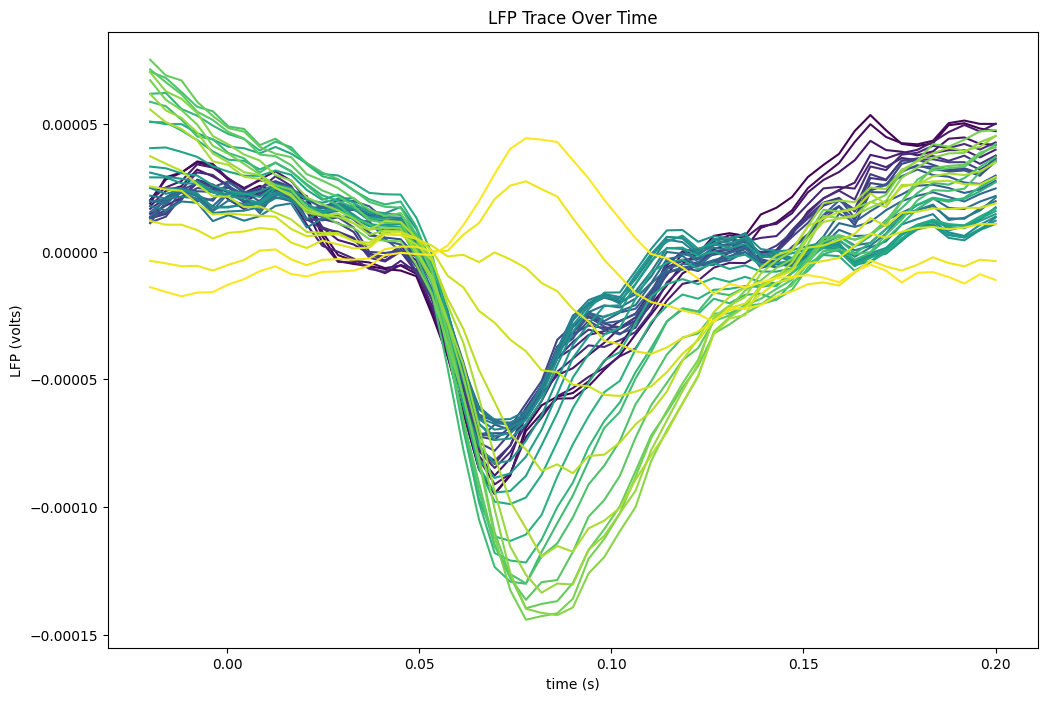

In [29]:
%matplotlib inline

xaxis = np.linspace(window_start_time, window_end_time, len(average_trace))
fig, ax = plt.subplots(figsize=(12,8))
colors = plt.cm.viridis(np.linspace(0, 1, n_channels))
ax.set_prop_cycle(color=colors)
ax.plot(xaxis, average_trace[:,start_channel:end_channel])

plt.xlabel("time (s)")
plt.ylabel("LFP (volts)")
plt.title("LFP Trace Over Time")
plt.show()

#### Traces from Channels Stacked

In [30]:
# Change this if the visualization below looks messy. The larger value the flatter
amp_res = 0.00002

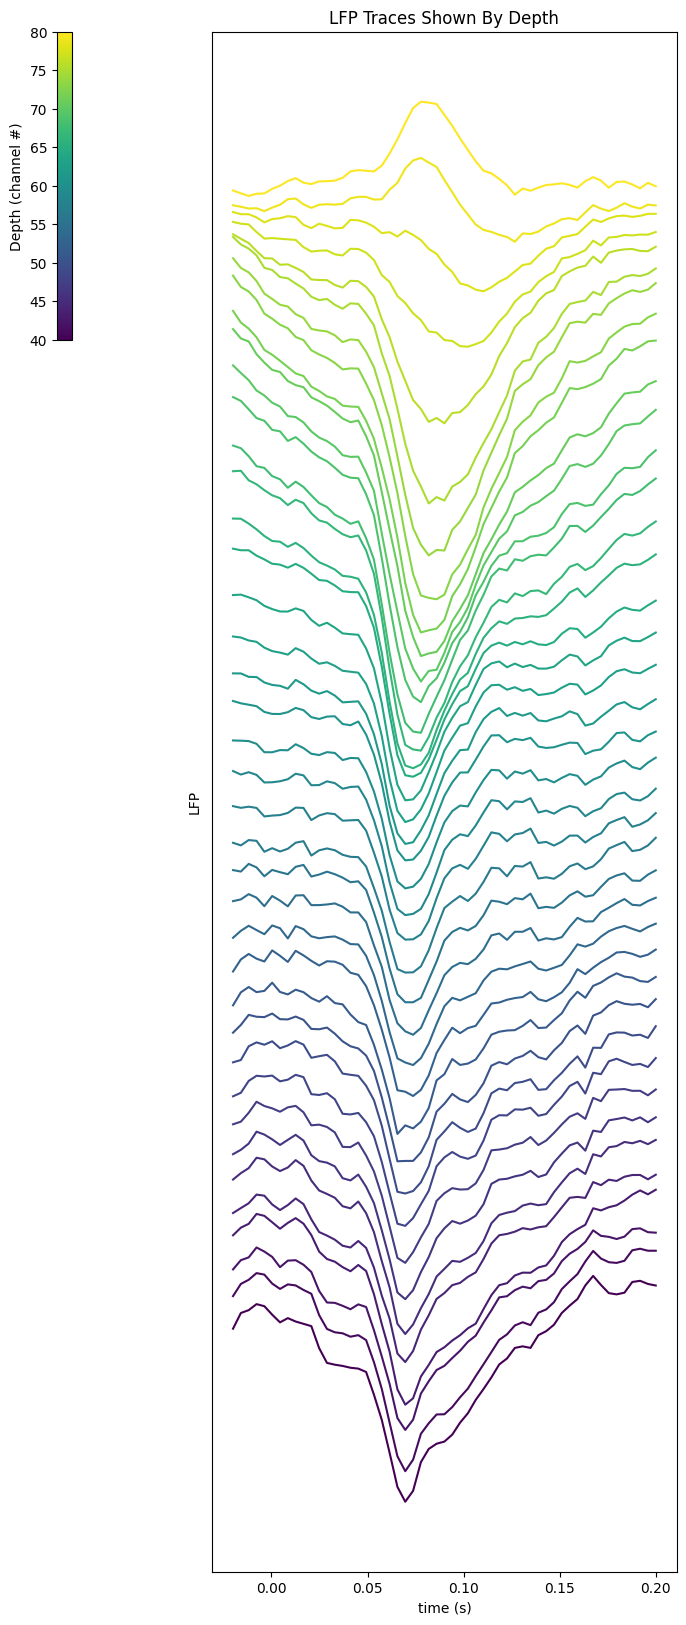

In [31]:
%matplotlib inline

xaxis = np.linspace(window_start_time, window_end_time, len(average_trace))
colors = plt.cm.viridis(np.linspace(0, 1, n_channels))
fig, ax = plt.subplots(figsize=(8, n_channels/2))

for i, channel in enumerate(range(start_channel, end_channel)):
    offset_trace = average_trace[:,channel] + i*amp_res
    plot = ax.plot(xaxis, offset_trace, color=colors[i])

norm = mpl.colors.Normalize(vmin=start_channel, vmax=end_channel)
cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm), location="left", anchor=(0,1), shrink=0.2, ax=ax, label='Depth (channel #)')
ax.yaxis.set_ticks([])
plt.xlabel("time (s)")
plt.ylabel("LFP")
plt.title("LFP Traces Shown By Depth")
plt.show()

#### Traces from Channels with Confidence Intervals

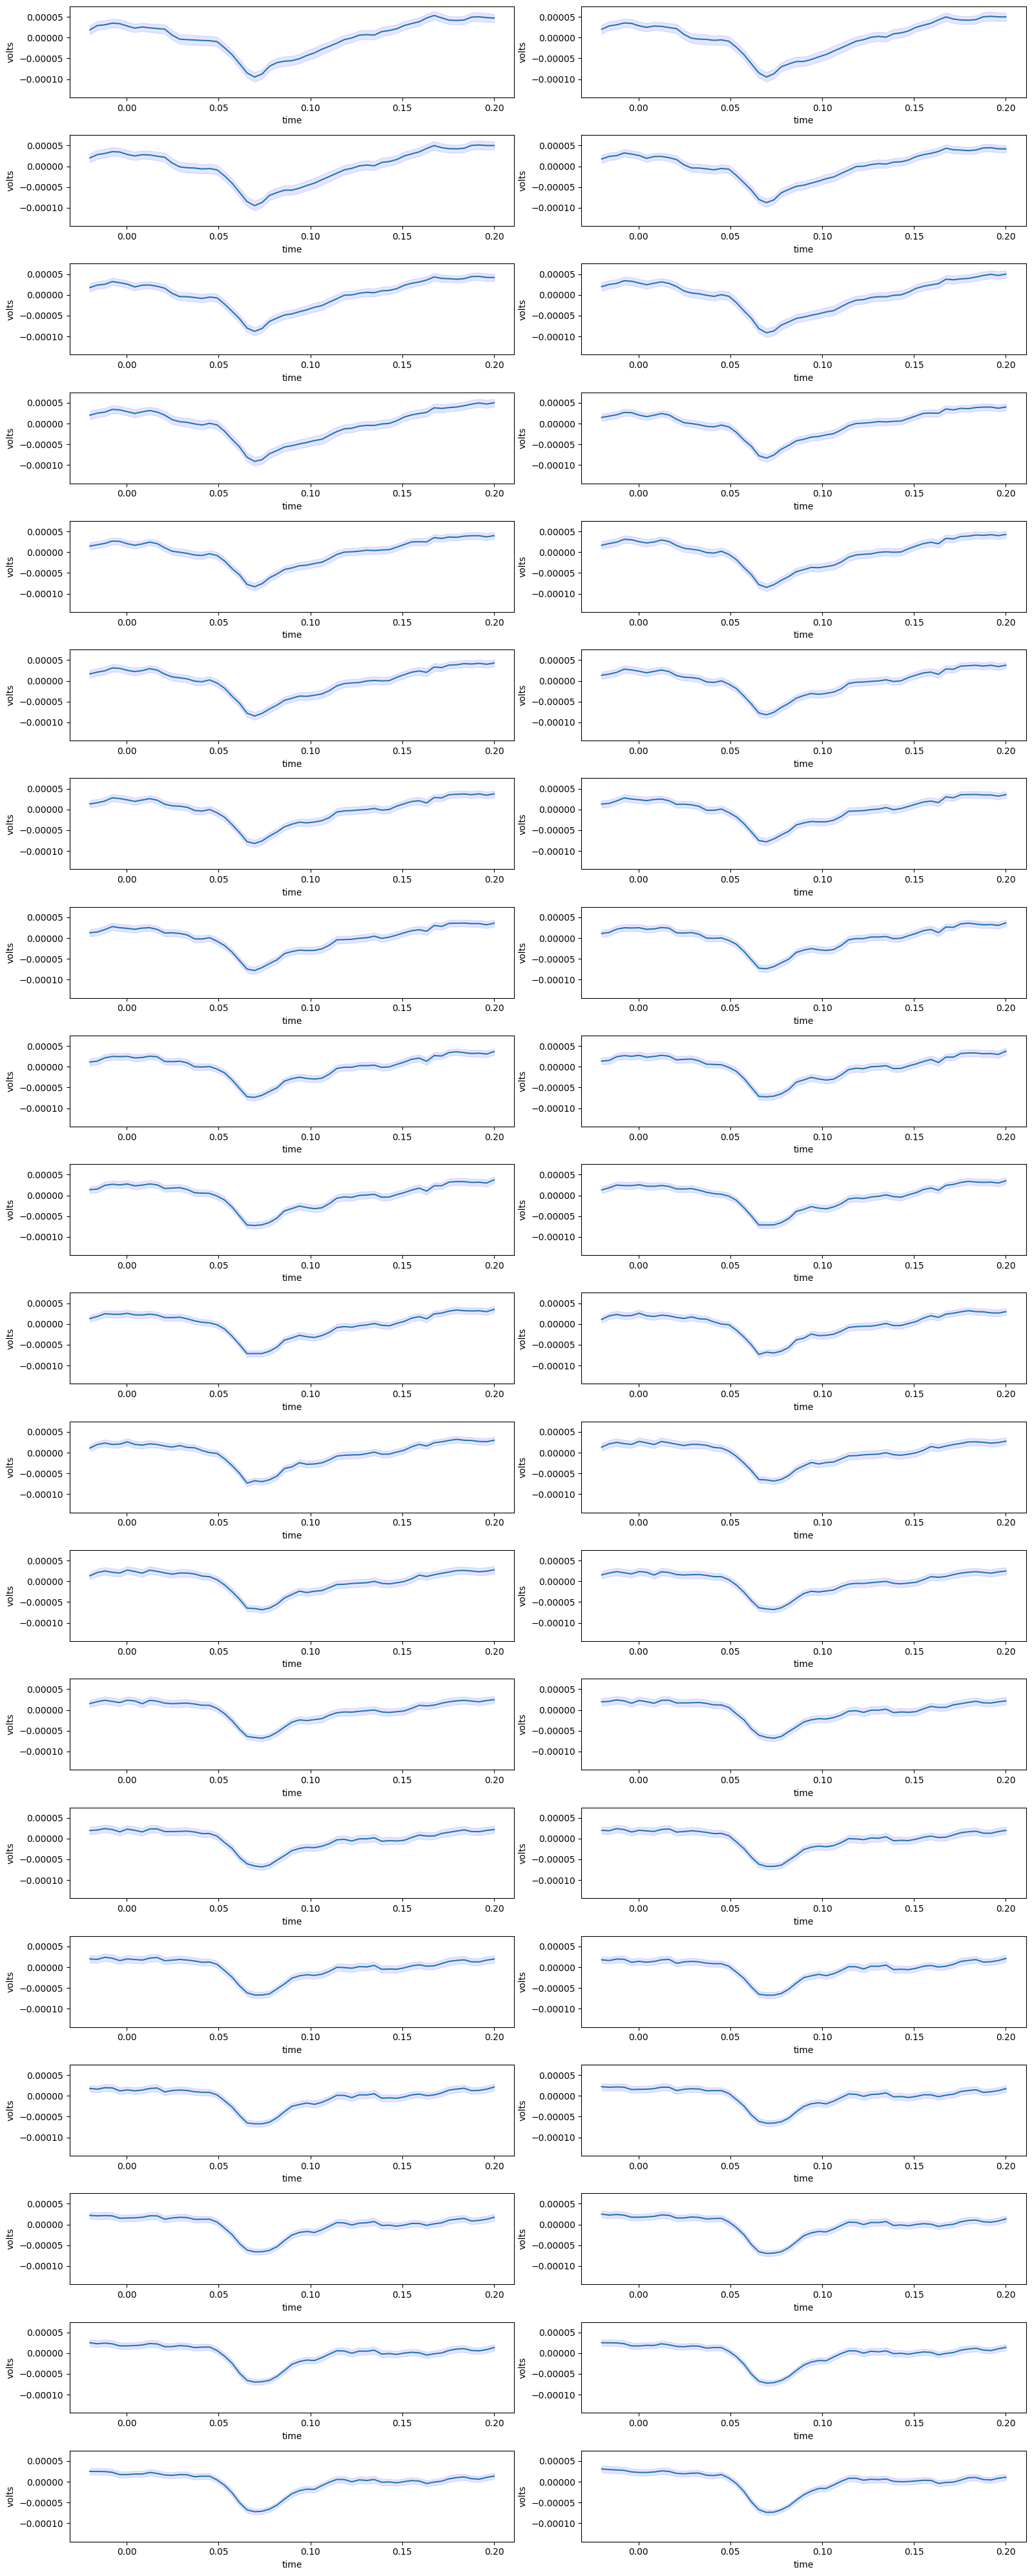

In [32]:
%matplotlib inline

fig, axs = plt.subplots(n_channels//2, 2, figsize=(16, n_channels))
xaxis = np.linspace(window_start_time, window_end_time, len(average_trace))

min_yval = np.amin(average_trace[:,start_channel:end_channel])
max_yval = np.amax(average_trace[:,start_channel:end_channel])
upper_bound = average_trace + (ci)
lower_bound = average_trace - (ci)

for i in range(n_channels // 2):
    for j in range(2):
        channel = start_channel + i + j
        ax = axs[i][j]

        ax.plot(xaxis, average_trace[:,channel])
        ax.fill_between(xaxis, lower_bound[:,channel], upper_bound[:,channel], color='b', alpha=.1)
        
        ax.set_ylim([min_yval, max_yval])
        ax.set_ylabel("volts")
        ax.set_xlabel("time")

plt.tight_layout()
plt.show()